In [25]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import scipy
from scipy.signal import cont2discrete
from scipy.linalg import solve_discrete_are
import scipy.linalg as la

# State-Space Model

In [26]:
# State variables
theta, omega, position, speed = sym.symbols('theta, omega, position, speed')

# Input torque
tau = sym.symbols('tau')

In [27]:
# Physical parameters
Jm, bm = sym.symbols('Jm, bm')       # motor inertia, damping
Mt, bt = sym.symbols('Mt, bt')       # table mass, damping
Kt = sym.symbols('Kt')              # torsional stiffness
pitch = sym.symbols('pitch')        # lead screw pitch


In [28]:
# gamma relates linear displacement to motor angle
gamma = 2 * sym.pi / pitch

In [29]:
# spring error
e = theta - gamma * position

# Differential equations
theta_dot = omega
omega_dot = (1/Jm) * (tau - bm*omega - Kt*e)
position_dot = speed
speed_dot = (1/Mt) * (Kt * gamma * e - bt * speed)

#### State Vector

In [30]:
# State vector
x_vec = sym.Matrix([
    [theta],
    [omega],
    [position],
    [speed],
])

# State derivative vector f(x,u)
f_vec = sym.Matrix([
    [theta_dot],
    [omega_dot],
    [position_dot],
    [speed_dot],
])

print(x_vec)
print(f_vec)

Matrix([[theta], [omega], [position], [speed]])
Matrix([[omega], [(-Kt*(theta - 2*pi*position/pitch) - bm*omega + tau)/Jm], [speed], [(2*pi*Kt*(theta - 2*pi*position/pitch)/pitch - bt*speed)/Mt]])


In [31]:
A_sym = f_vec.jacobian(x_vec)                 # ∂f/∂x
B_sym = f_vec.jacobian(sym.Matrix([tau]))     # ∂f/∂u

A_sym, B_sym

(Matrix([
 [                 0,      1,                         0,      0],
 [            -Kt/Jm, -bm/Jm,        2*pi*Kt/(Jm*pitch),      0],
 [                 0,      0,                         0,      1],
 [2*pi*Kt/(Mt*pitch),      0, -4*pi**2*Kt/(Mt*pitch**2), -bt/Mt]]),
 Matrix([
 [   0],
 [1/Jm],
 [   0],
 [   0]]))

In [32]:
# Output matrix: y = [position, theta, speed]
C_sym = sym.Matrix([
    [0, 0, 1, 0],  # table position
    [1, 0, 0, 0],  # motor angle
    [0, 0, 0, 1],  # table speed
])

D_sym = sym.Matrix([[0], [0], [0]])
C_sym, D_sym

(Matrix([
 [0, 0, 1, 0],
 [1, 0, 0, 0],
 [0, 0, 0, 1]]),
 Matrix([
 [0],
 [0],
 [0]]))

#### Parameter Values

In [33]:
param_values = {
    Jm:    1e-4,    # motor inertia [kg m^2] 
    bm:    1e-4,    # motor damping
    Mt:    2.0,     # table mass [kg]
    bt:    20.0,    # table damping
    Kt:    5e5,     # torsional stiffness [N m / rad]
    pitch: 0.008    # 8 mm per revolution
}


A_num = A_sym.subs(param_values)
B_num = B_sym.subs(param_values)
C_num = C_sym.subs(param_values)
D_num = D_sym.subs(param_values)

A_num, B_num

(Matrix([
 [            0,    1,                    0,     0],
 [-5000000000.0, -1.0,   1250000000000.0*pi,     0],
 [            0,    0,                    0,     1],
 [62500000.0*pi,    0, -15625000000.0*pi**2, -10.0]]),
 Matrix([
 [      0],
 [10000.0],
 [      0],
 [      0]]))

In [34]:
# Sampling time

Ts = 1e-3  # 1 ms

def build_discrete_model(Jm_val, Mt_val, Kt_val, bm_val, bt_val, pitch_val, Ts):
    """
    Substitute physical parameters into the symbolic model,
    convert to numpy, and discretize.
    """

    param_values = {
        Jm:    Jm_val,
        bm:    bm_val,
        Mt:    Mt_val,
        bt:    bt_val,
        Kt:    Kt_val,
        pitch: pitch_val
    }

    # Substitute into symbolic matrices
    A_num = A_sym.subs(param_values)
    B_num = B_sym.subs(param_values)
    C_num = C_sym.subs(param_values)
    D_num = D_sym.subs(param_values)

    # SymPy -> numpy
    A = np.array(A_num, dtype=float)
    B = np.array(B_num, dtype=float)
    C = np.array(C_num, dtype=float)
    D = np.array(D_num, dtype=float)

    # Discretize
    Ad, Bd, Cd, Dd, _ = cont2discrete((A, B, C, D), Ts)

    return A, B, C, D, Ad, Bd, Cd, Dd

# ---- Nominal parameters (same numbers used in param_values)
Jm_nom    = 1e-4
bm_nom    = 1e-4
Mt_nom    = 2.0
bt_nom    = 20.0
Kt_nom    = 5e5
pitch_nom = 0.008

# Build nominal continuous and discrete models
A, B, C, D, Ad, Bd, Cd, Dd = build_discrete_model(
    Jm_nom, Mt_nom, Kt_nom, bm_nom, bt_nom, pitch_nom, Ts
)

Ad.shape, Bd.shape, Cd.shape, Dd.shape


((4, 4), (4, 1), (3, 4), (3, 1))

#### Open-Loop Simulation

In [35]:
def simulate_open_loop(Ad, Bd, Cd, Dd, tau_value, N_steps, x0=None):
    n = Ad.shape[0]          # number of states
    p = Cd.shape[0]          # number of outputs

    if x0 is None:
        x0 = np.zeros(n)
    else:
        x0 = np.asarray(x0).reshape(n,)   # force 1D

    xs = np.zeros((N_steps + 1, n))
    ys = np.zeros((N_steps, p))
    us = np.zeros((N_steps, 1))

    xs[0, :] = x0

    for k in range(N_steps):
        u_k = np.array([[tau_value]], dtype=float)  # (1,1)
        us[k] = u_k

        x_next = Ad @ xs[k, :].reshape(n, 1) + Bd @ u_k   # (4,1)
        y_k    = Cd @ xs[k, :].reshape(n, 1) + Dd @ u_k   # (p,1)

        xs[k+1, :] = x_next.ravel()
        ys[k, :]   = y_k.ravel()

    return xs, ys, us


#### Open-Loop Test

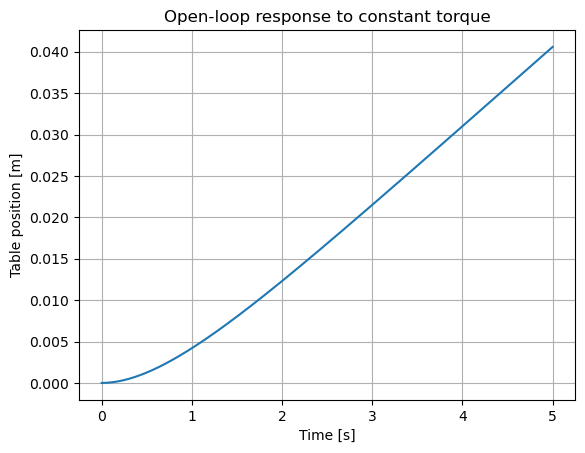

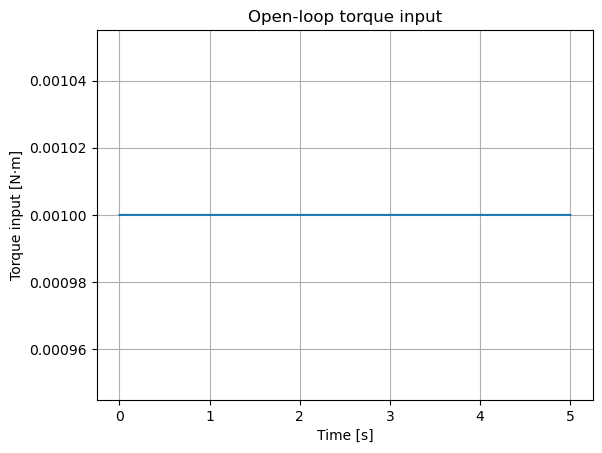

max position = 0.0405813153612657
final position = 0.0405813153612657


In [36]:
# Plots
N_steps  = 5000          # 5 seconds at Ts = 1e-3
tau_step = 1e-3          # 0.001 N·m, small but visible

xs_ol, ys_ol, us_ol = simulate_open_loop(Ad, Bd, Cd, Dd, tau_step, N_steps)

time = Ts * np.arange(N_steps)

pos_ol   = ys_ol[:, 0]   # table position
theta_ol = ys_ol[:, 1]   # motor angle (since Cd has that too, if you want)


plt.figure()
plt.plot(time, pos_ol)
plt.xlabel("Time [s]")
plt.ylabel("Table position [m]")
plt.grid(True)
plt.title("Open-loop response to constant torque")
plt.show()

plt.figure()
plt.plot(time, us_ol[:, 0])
plt.xlabel("Time [s]")
plt.ylabel("Torque input [N·m]")
plt.grid(True)
plt.title("Open-loop torque input")
plt.show()

print("max position =", np.max(pos_ol))
print("final position =", pos_ol[-1])



#### Open-Loop Behavior Discussion

The open-loop simulation shows that applying a constant motor torque causes the table position to increase without bound. This happens because the axis contains no natural restoring force in the translational direction: with no controller present, the applied torque produces a nearly constant acceleration, so the table continues to move indefinitely instead of settling at a new equilibrium. 

This behavior is physically consistent with a real CNC axis driven by a ball screw, where the table behaves like a free mass unless actively controlled. The open-loop response therefore exhibits unbounded drift and no ability to regulate or hold a commanded position, demonstrating that the system is open-loop unstable in the practical sense. This motivates the need for a closed-loop control strategy: only with feedback can the axis reject disturbances, counteract constant torques, and converge to a desired position with finite settling time.


In [37]:
# State weights with Bryson's Rule

theta_max = 0.1        # rad
omega_max = 50.0       # rad/s
x_max     = 0.05       # m
v_max     = 0.10       # m/s

Q = np.diag([
    1.0 / theta_max**2,   # theta
    1.0 / omega_max**2,   # omega
    1.0 / x_max**2,       # table position
    1.0 / v_max**2        # table speed
])

# Input weight

R = np.array([[64.0]])    # tune later - bigger R, softer control


# Discrete algebraic Riccati equation
P = solve_discrete_are(Ad, Bd, Q, R)

# LQR gain
K_lqr = np.linalg.inv(Bd.T @ P @ Bd + R) @ (Bd.T @ P @ Ad)

print(K_lqr)


[[-1.17043598e+00  1.50836826e-02  1.82692595e+03  3.75331511e-01]]


In [38]:
# pre-compensator
n = Ad.shape[0]
I = np.eye(n)

# Closed-loop A matrix with state feedback
A_cl = Ad - Bd @ K_lqr  

# First output row: position
C_pos = Cd[0, :].reshape(1, -1)   # shape (1,4)

# Steady-state gain from input u to position y
G = C_pos @ np.linalg.inv(I - A_cl) @ Bd   # shape (1,1)

N_r = float(1.0 / G[0, 0])  # scalar precompensator
N_r

907.6676832298989

  #### Precompensator

  Acts as a filter or network, placed before the plant, to modify its dynamics. Its serves as a starting point to improve performance through decooupling of inouts and outputs in multi-variable systems, focused on improving transient response and reducing steady state errors. 

  Precompensators work in feedforward to adjust signals before they enter the main loop, thus, compliment feedback control.

##### Error Source Parameters

In [39]:
#  Disturbance toggles
USE_DIST_TORQUE    = True
USE_SENSOR_NOISE   = True
USE_QUANTIZATION   = False
USE_PARAM_MISMATCH = False

# Disturbance Parameters

tau_dist = 0.02     # torque (Nm)
sigma_noise = 3e-4   # Sensor noise STD (meters) 
quant_res = 1e-4    # Quantization resolution (meters)      

# Parameter mismatch factors

J_sim_factor  = 1.10     # +10%
Mt_sim_factor  = 1.15     # +15%
Kt_sim_factor = 0.90     # -10%


In [40]:
if USE_PARAM_MISMATCH:
    Jm_sim  = Jm_nom  * J_sim_factor
    Mt_sim  = Mt_nom  * Mt_sim_factor
    Kt_sim  = Kt_nom  * Kt_sim_factor

    A_sim, B_sim, C_sim, D_sim, Ad_sim, Bd_sim, Cd_sim, Dd_sim = build_discrete_model(
        Jm_sim, Mt_sim, Kt_sim, bm_nom, bt_nom, pitch_nom, Ts
    )
else:
    Ad_sim = Ad
    Bd_sim = Bd
    Cd_sim = Cd
    D_sim  = D


### Error Sources Explained

#### Added Error Sources and Physical Motivation

To make the digital twin more representative of a real CNC axis, several non-idealities were incorporated into the closed-loop simulation. These errors account for imperfections that arise in practical machining systems and allow the controller to be evaluated under realistic operating conditions.

1. Disturbance Torque (Cutting Load)

During machining, the interaction between the cutting tool and the workpiece generates reaction forces that feed back through the leadscrew and into the motor shaft. These forces behave like external torques acting on the axis. In the simulation, a small disturbance torque is added to the motor input to represent this effect. This tests the controller’s ability to maintain position in the presence of persistent loading. As expected for a state-feedback controller without integral action, the axis exhibits a small steady-state torque offset to counteract the disturbance, matching real CNC behavior where the motor must “push back” to hold position.

2. Sensor Noise (Encoder Noise)

The table position used for feedback is never perfectly clean in a real machine. Encoders introduce electrical noise, quantization, and jitter due to resolution limits and detection electronics. To reflect this, Gaussian noise is added to the measured position signal. The level is small enough to avoid destabilizing the controller but large enough to demonstrate realistic jitter in the closed-loop response. This tests how sensitive the state-feedback law is to sensor imperfections and shows that the controller remains stable even with noisy measurements.

3. Quantization (Finite Measurement Resolution)

Real position sensors cannot measure arbitrarily fine details; they report values only at discrete increments (e.g., 0.1 mm). This effect is modeled by rounding the noisy position measurement to a fixed resolution. Quantization demonstrates that closed-loop tracking remains stable when feedback information is coarse, as would be the case with lower-resolution encoders or microstepping feedback in stepper-driven systems.

4. Parameter Mismatch (Modeling Error)

Mechanical parameters such as mass, inertia, damping, and screw stiffness vary with temperature, wear, lubrication, and manufacturing tolerances. The controller, however, is designed using nominal values. To capture this discrepancy, the simulation includes the option to modify plant parameters by ±10–15%. This tests whether the controller remains effective even when the true system does not match the mathematical model used in design—a critical robustness consideration for any real machine tool.

#### Summary

These non-idealities help transform the simulation from an idealized mathematical model into a realistic digital twin of a CNC axis. By evaluating the controller under disturbance loads, sensor noise, quantization, and potential parameter variations, we can better assess its stability, robustness, and suitability for real-world implementation.

#### Closed-Loop Simulation

In [41]:
def simulate_closed_loop(Ad, Bd, K, N_r, x_ref, N_steps, Ts, u_max=0.25):
    """
    Closed-loop simulation for LQR tracking a constant position reference.
    """
    """
    modify parameters (if your Ad, Bd depend on J, m, Kt... you recompute THEM here)
    Example (only if your matrices depend on Kt, m, J):
    Kt_sim = Kt * Kt_sim_factor
    (then rebuild Ad_sim, Bd_sim using Kt_sim, m_sim, J_sim)

    If your current Ad/Bd are constant numerical matrices,
    you skip this step until we rewrite Ad,Bd from parameters.
    """


    n = Ad.shape[0]
    x = np.zeros((n, 1))

    xs = np.zeros((N_steps, n))
    ys = np.zeros(N_steps)
    us = np.zeros(N_steps)

    Cpos = np.array([[0., 0., 1., 0.]])  # position output

    # apply parameter mismatch to plant matrices
    if USE_PARAM_MISMATCH:
        A_used = Ad_sim
        B_used = Bd_sim
    else:
        A_used = Ad
        B_used = Bd

    for k in range(N_steps):

        # true output
        y_true = float(Cpos @ x)

        # --- measurement noise ---
        if USE_SENSOR_NOISE:
            y_meas = y_true + np.random.normal(0.0, sigma_noise)
        else:
            y_meas = y_true

        # --- quantization ---
        if USE_QUANTIZATION:
            y_meas = np.round(y_meas / quant_res) * quant_res

        # Controller still uses true x (state vector)

        # --- state feedback ---
        u = float(-K @ x + N_r * x_ref)

        # --- saturation ---
        u = np.clip(u, -u_max, u_max)

        # --- disturbance torque --
        if USE_DIST_TORQUE:
            u_eff = u + tau_dist
        else:
            u_eff = u

        # --- update dynamics ---
        x = A_used @ x + B_used * u_eff


        # --- store ---
        xs[k, :] = x.ravel()
        ys[k]    = y_meas
        us[k]    = u

    t = Ts * np.arange(N_steps)
    return t, xs, ys, us

#### Closed-Loop Test & Plot

/var/folders/xj/s_t94s8n46xgmygg7rb3ff4c0000gn/T/ipykernel_22833/2423721397.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_true = float(Cpos @ x)
/var/folders/xj/s_t94s8n46xgmygg7rb3ff4c0000gn/T/ipykernel_22833/2423721397.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = float(-K @ x + N_r * x_ref)


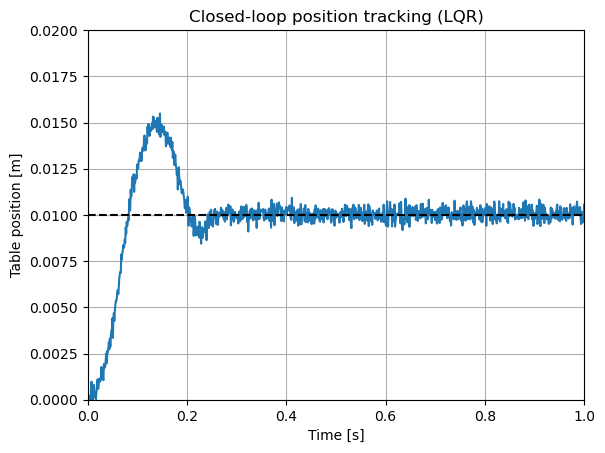

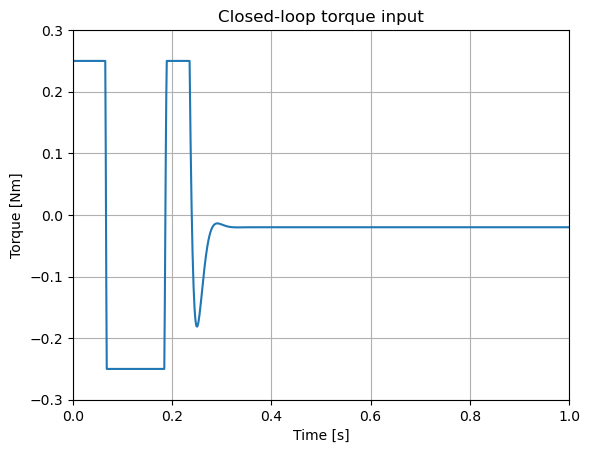

In [42]:
N_steps = 3000
x_ref   = 0.01   # 1 cm

t, xs_cl, y_cl, u_cl = simulate_closed_loop(
    Ad, Bd, K_lqr, N_r, x_ref, N_steps, Ts, u_max=0.25
)

# Position plot
plt.figure()
plt.plot(t, y_cl)
plt.axhline(x_ref, linestyle="--", color="black")
plt.xlabel("Time [s]")
plt.ylabel("Table position [m]")
plt.title("Closed-loop position tracking (LQR)")
plt.grid(True)
plt.xlim(0, 1.0)
plt.ylim(0, 0.02)

# Torque plot
plt.figure()
plt.plot(t, u_cl)
plt.xlabel("Time [s]")
plt.ylabel("Torque [Nm]")
plt.title("Closed-loop torque input")
plt.grid(True)
plt.xlim(0, 1.0)
plt.ylim(-0.3, 0.3) 

plt.show()


In [43]:
print("A:", A)
print("B:", B)
print("Ad:", Ad)
print("Bd:", Bd)


A: [[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.00000000e+09 -1.00000000e+00  3.92699082e+12  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 1.96349541e+08  0.00000000e+00 -1.54212569e+11 -1.00000000e+01]]
B: [[    0.]
 [10000.]
 [    0.]
 [    0.]]
Ad: [[ 9.37085710e-01  9.67972013e-04  4.94127678e+01  2.46512487e-02]
 [ 4.01295985e+02  9.36117738e-01 -3.15177129e+05  4.91662553e+01]
 [ 2.45954533e-03  1.23256243e-06 -9.31722384e-01  3.13065728e-05]
 [-1.57809813e+01  2.45831277e-03  1.23943537e+04 -9.32035450e-01]]
Bd: [[4.84091125e-03]
 [9.67972013e+00]
 [6.16347943e-06]
 [1.23256243e-02]]
